In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [8]:
from datasets import load_dataset

# Load the Falah/Alzheimer_MRI dataset
dataset = load_dataset('Falah/Alzheimer_MRI', split='train')


In [9]:
# Split training data into train and validation tensorflow datasets

datasets = dataset.train_test_split(test_size=0.2)
ds_train_ = datasets["train"].to_tf_dataset(columns='image', shuffle=True, label_cols='label')
ds_valid_ = datasets["test"].to_tf_dataset(columns='image', shuffle=False, label_cols='label')

In [10]:
# Data Pipeline
# Converts image to float, and add one grayscale channel
def preprocess(image, label):
    image = tf.expand_dims(image, axis=-1)  # Shape becomes (128, 128, 1)
    image = tf.image.grayscale_to_rgb(image) # Shape become (128, 128, 3)
    
    image = tf.cast(image, tf.float32)
    # Normalize pixel values to [0, 1]
    image /= 255.0
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(preprocess)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(preprocess)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

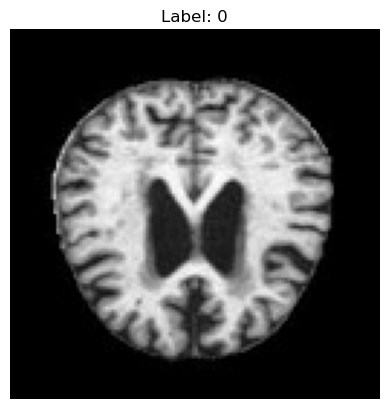

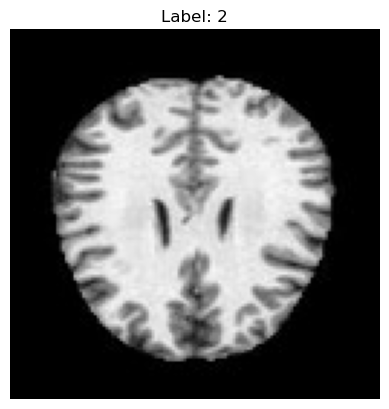

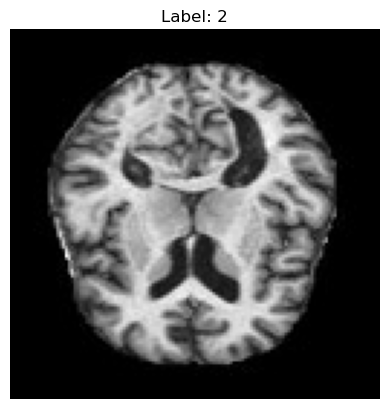

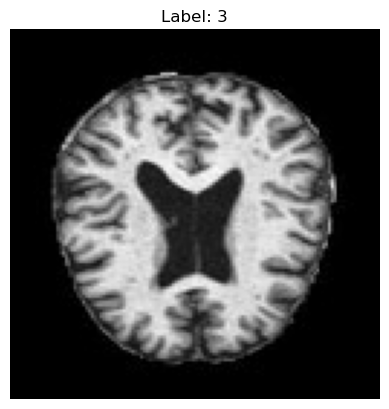

2024-11-14 17:22:07.189569: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


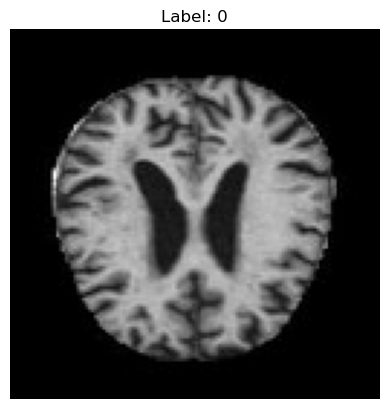

In [11]:
# Take a look at some of our sample MRI data
for image, label in ds_train.take(5): 
    # Convert image to numpy array and display with matplotlib 
    plt.imshow(image.numpy()) # Convert TensorFlow tensor to a NumPy array
    plt.title(f"Label: {label.numpy()}") # Print label
    plt.axis('off')
    plt.show()

In [12]:
# Batch our datasets
ds_train = ds_train.batch(batch_size=64)
ds_valid = ds_valid.batch(batch_size=64)

In [13]:
# Now import VGG16 base model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable =False

In [14]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

model = keras.Sequential([
    # preprocessing.RandomFlip('horizontal'),
    base_model,
    layers.Flatten(),
    layers.Dense(20, activation='relu'),
    layers.Dense(4, activation='softmax'),
])

In [15]:
model.summary()
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy', # As labels are in form of integers 0-3
    metrics = ['accuracy']
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 20)                163860    
                                                                 
 dense_3 (Dense)             (None, 4)                 84        
                                                                 
Total params: 14,878,632
Trainable params: 163,944
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
    verbose=True
)

Epoch 1/30
64/64 [==============================] - 55s 861ms/step - loss: 0.8310 - accuracy: 0.5874 - val_loss: 0.8296 - val_accuracy: 0.5977
Epoch 2/30
64/64 [==============================] - 60s 935ms/step - loss: 0.8209 - accuracy: 0.5935 - val_loss: 0.8212 - val_accuracy: 0.6006
Epoch 3/30
64/64 [==============================] - 64s 1s/step - loss: 0.8112 - accuracy: 0.5989 - val_loss: 0.8132 - val_accuracy: 0.6055
Epoch 4/30
64/64 [==============================] - 57s 888ms/step - loss: 0.8017 - accuracy: 0.6055 - val_loss: 0.8056 - val_accuracy: 0.6113
Epoch 5/30
64/64 [==============================] - 56s 870ms/step - loss: 0.7925 - accuracy: 0.6106 - val_loss: 0.7984 - val_accuracy: 0.6152
Epoch 6/30
64/64 [==============================] - 60s 940ms/step - loss: 0.7836 - accuracy: 0.6189 - val_loss: 0.7916 - val_accuracy: 0.6172
Epoch 7/30
64/64 [==============================] - 55s 865ms/step - loss: 0.7748 - accuracy: 0.6238 - val_loss: 0.7852 - val_accuracy: 0.6182
Ep

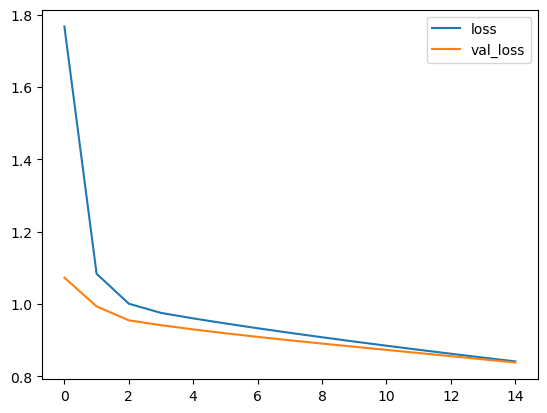

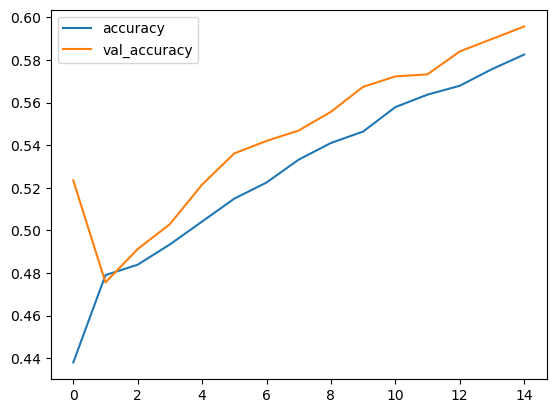

In [17]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();